# 5. Gaussian Processes

At the end of this exercise you will be more familiar with Gaussian Processes and the way they work in practice, as well as how you can adapt them to your problems (such as the ones on the mock exam)

* Training Setup
* GP Regression
* GP Classification

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

# Helper library to more efficiently handle Gaussian Processes in PyTorch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pyro.set_rng_seed(0)

## Tl;dr of Gaussian Process Theory

Why GPs?
* Elegant mathematical theory which affords us guarantees for our predictive model's behaviour
* Conceptually, they give us a way to define priors over functions
* Are able to reason over uncertainty as they are rooted in the Bayesian setting

As GPs do in practice require a tiny bit of infrastructure below them to work, and be efficient, we will rely on [Pyro](https://github.com/pyro-ppl/pyro) to provide us with the required abstractions. Our model is defined as

$$
f \sim \mathcal{GP}\left( 0, \text{K}_{f}(x, x') \right)
$$

with our presumed data following the relationship

$$
y = f(x) + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \beta^{-1} \textbf{I})
$$

where $x$, $x'$ are points in the input space, and y is a point in the output space. $f$ then represents a function from the input space to the output space in which we **draw** from the Gaussian Process prior specified by the mean, and the kernel.

As already mentioned in the lecture, the radial basis function is one of the most common kernels and one which you have probably by now also encountered in use with Support Vector Machines:

$$
k(x, x') = \sigma^{2} \text{exp} \left( - \frac{|| x - x' ||^{2}}{2 l^{2}}  \right)
$$

where the variance $\sigma^{2}$, and lengthscale $l$ are kernel specification parameters.

## Gaussian Processes from Sketch

In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [3]:
class GaussianProcess(nn.Module):

    """Gaussian process regression model.

    Built for multi-input, single-output functions.
    """
    def __init__(self, kernel, sigma_n=None, eps=1e-6):
        """Constructs an instance of a Gaussian process.

        Args:
            kernel (Kernel): Kernel
            sigma_n (Tensor): Noise standard deviation
            eps (Float): Minimum bound for parameters.
        """
        super(GaussianProcess, self).__init__()
        self.kernel = kernel
        self.sigma_n = torch.nn.Parameter(
            torch.randn(1) if sigma_n is None else sigma_n
        )
        self._eps = eps
        self._is_set = False

    def _update_k(self):
        """Update the K matrix."""
        X = self._X
        Y = self._Y

        # Compute K and guarantee it is positive definite
        var_n = (self.sigma_n**2).clamp(self._eps, 1e5)
        K = self.kernel(X, X)
        K = (K + K.t()).mul(0.5)
        self._K = K + (self._reg + var_n) * torch.eye(X.shape[0])

        # Compute K's inverse and Cholesky factorization
        self._L = torch.cholesky(self._K)
        self._K_inv = self._K.inverse()
    
    def set_data(self, X, Y, normalize_y=True, reg=1e-5):
        """Set the training data.

        Args:
            X (Tensor): Training inputs
            Y (Tensor): Training outputs
            normalize_y (Boolean): Normalize the outputs
        """
        self._non_normalized_Y = Y

        if normalize_y:
            Y_mean = torch.mean(Y, dim=0)
            Y_variance = torch.std(Y, dim=0)
            Y = (Y - Y_mean) / Y_variance
        
        self._X = X
        self._Y = Y
        self._reg = reg
        self._update_k()
        self._is_set = True
    
    def loss(self):
        """Negative marginal log likelihood."""
        if not self._is_set:
            raise RuntimeError("You must call set_data() first")

        Y = self._Y
        self._update_k()
        K_inv = self._K_inv

        # Compute the log likelihood
        log_likelihood_dims = -0.5 * Y.t().mm(K_inv.mm(Y)).sum(dim=0)
        log_likelihood_dims -= self._L.diag().log().sum()
        log_likelihood_dims -= self._L.shape[0] / 2.0 * np.log(2 * np.pi)
        log_likelihood = log_likelihood_dims.sum(dim=-1)

        return -log_likelihood
    
    def forward(self,
                x,
                return_mean=True,
                return_var=False,
                return_covar=False,
                return_std=False,
                **kwargs):
        """Compute the GP estimate.

        Args:
            x (Tensor): Inputs
            return_mean (Boolean): Return the mean
            return_covar (Boolean): Return the full covariance matrix
            return_var (Boolean): Return the variance
            return_std (Boolean): Return the standard deviation
        
        Returns:
            Tensor or tuple of Tensors.
            The order of the tuple if all outputs are requested is:
                (mean, covariance, variance, standard deviation)
        """
        if not self._is_set:
            raise RuntimeError("You must call set_data() first")
        
        X = self._X
        Y = self._Y
        K_inv = self._K_inv

        # Kernel functions
        K_ss = self.kernel(x, x)
        K_s = self.kernel(x, X)

        # Compute the mean
        outputs = []
        if return_mean:
            # Non-normalized for scale
            mean = K_s.mm(K_inv.mm(self._non_normalized_Y))
            outputs.append(mean)
        
        # Compute covariance/variance/standard deviation
        if return_covar or return_var or return_std:
            covar = K_ss - K_s.mm(K_inv.mm(K_s.t()))
            if return_covar:
                outputs.append(covar)
            if return_var or return_std:
                var = covar.diag().reshape(-1, 1)
                if return_var:
                    outputs.append(var)
                if return_std:
                    std = var.sqrt()
                    outputs.append(std)
        
        if len(outputs) == 1:
            return outputs[0]
        
        return tuple(outputs)
    
    def fit(self, tol=1e-6, reg_factor=10.0, max_reg=1.0, max_iter=1000):
        """Fits the model to the data.

        Args:
            tol (Float): Tolerance
            reg_factor (Float): Regularization multiplicative factor
            max_reg (Float): Maximum regularization term
            max_iter (Integer): Maximum number of iterations
        
        Returns:
            Number of iterations.
        """
        if not self._is_set:
            raise RuntimeError("You must call set_data() first")
            
        opt = torch.optim.Adam(p for p in self.parameters() if p.requires_grad)

        while self._reg <= max_reg:
            try:
                curr_loss = np.inf
                n_iter = 0

                while n_iter < max_iter:
                    opt.zero_grad()

                    prev_loss = self.loss()
                    prev_loss.backward(retain_graph=True)
                    opt.step()

                    curr_loss = self.loss()
                    dloss = curr_loss - prev_loss
                    n_iter += 1
                    if dloss.abs() <= tol:
                        break
                
                return n_iter
            except RuntimeError:
                # Increase regularization term until it succeeds
                self._reg *= reg_factor
                continue

For which we then need to define our kernel base class

In [4]:
class Kernel(nn.Module):
    """Base class for the kernel functions."""

    def __add__(self, other):
        """Sums two kernels together.and
        
        Args:
            other (Kernel): Other kernel.
        
        Returns:
            Aggregate Kernel
        """
        return AggregateKernel(self, other, torch.add)
    
    def __mul__(self, other):
        """Multiplies two kernel together.

        Args:
            other (Kernel): Other kernel
        
        Returns:
            Aggregate Kernel
        """
        return AggregateKernel(self, other, torch.mul)
    
    def __sub__(self, other):
        """Subtracts two kernels from each other.

        Args:
            other (Kernel): Other kernel
        
        Returns:
            Aggregate Kernel
        """
        return AggregateKernel(self, other, torch.sub)
    
    def forward(self, xi, xj, *args, **kwargs):
        """Covariance function

        Args:
            xi (Tensor): First matrix
            xj (Tensor): Second matrix
        
        Returns:
            Covariance (Tensor)
        """
        raise NotImplementedError


class AggregateKernel(Kernel):
    """An aggregate kernel."""

    def __init__(self, first, second, op):
        """Constructs an Aggregate Kernel

        Args:
            first (Kernel): First kernel
            second (Kernel): Second kernel
            op (Function): Operation to apply
        """
        super(Kernel, self).__init__()
        self.first = first
        self.second = second
        self.op = op
    
    def forward(self, xi, xj, *args, **kwargs):
        """Covariance function

        Args:
            xi (Tensor): First matrix
            xj (Tensor): Second matrix
        
        Returns:
            Covariance (Tensor)
        """
        first = self.first(xi, xj, *args, **kwargs)
        second = self.second(xi, xj, *args, **kwargs)
        return self.op(first, second)

def mahalanobis_squared(xi, xj, VI=None):
    """Computes the pair-wise squared mahalanobis distance matrix.

    Args:
        xi (Tensor): xi input matrix
        xj (Tensor): xj input matrix
        VI (Tensor): The inverse of the covariance matrix, by default the
            identity matrix
    
    Returns:
        Weighted matrix of all pair-wise distances (Tensor)
    """
    if VI is None:
        xi_VI = xi
        xj_VI = xj
    else:
        xi_VI = xi.mm(VI)
        xj_VI = xj.mm(VI)
    
    D_squared = (xi_VI * xi).sum(dim=-1).reshape(-1, 1) \
                + (xj_VI * xj).sum(dim=-1).reshape(1, -1) \
                - 2 * xi_VI.mm(xj.t())
    
    return D_squared

With which we can then define the RBF Kernel, and the White Noise Kernel

In [5]:
class RBFKernel(Kernel):

    """Radial-basis function kernel."""
    
    def __init__(self, length_scale=None, sigma_s=None, eps=1e-6):
        """Constructs an RBF Kernel

        Args:
            length_scale (Tensor): Length scale
            sigma_s (Tensor): Signal standard deviation
            eps (Float): Minimum bound for parameters
        """
        super(Kernel, self).__init__()
        self.length_scale = torch.nn.Parameter(
            torch.randn(1) if length_scale is None else length_scale
        )
        self.sigma_s = torch.nn.Parameter(
            torch.randn(1) if sigma_s is None else sigma_s
        )
        self._eps = eps
    
    def forward(self, xi, xj, *args, **kwargs):
        """Covariance function

        Args:
            xi (Tensor): First matrix
            xj (Tensor): Second matrix
        
        Returns:
            Covariance (Tensor)
        """
        length_scale = (self.length_scale**-2).clamp(self._eps, 1e5)
        var_s = (self.sigma_s**2).clamp(self._eps, 1e5)

        M = torch.eye(xi.shape[1]) * length_scale
        dist = mahalanobis_squared(xi, xj, M)
        return var_s * (-0.5 * dist).exp()

In [6]:
class WhiteNoiseKernel(Kernel):

    """White noise kernel."""

    def __init__(self, sigma_n=None, eps=1e-6):
        """Instantiates a white noise kernel

        Args:
            sigma_n (Tensor): Noise standard deviation
            eps (Float): Minimum bound for parameters
        """
        super(Kernel, self).__init__()
        self.sigma_n = torch.nn.Parameter(
            torch.randn(1) if sigma_n is None else sigma_n
        )
        self._eps = eps
    
    def forward(self, xi, xj, *args, **kwargs):
        """Covariance function

        Args:
            xi (Tensor): First matrix
            xj (Tensor): Second matrix
        
        Returns:
            Covariance (Tensor)
        """
        var_n = (self.sigma_n**2).clamp(self._eps, 1e5)
        return var_n

We can now set up the training and test data to test this handwritten implementation

In [7]:
X = 10 * torch.rand(50, 1) - 4
X_train = torch.tensor(sorted(torch.cat([X] * 4))).reshape(-1, 1)

In [8]:
import math

def real_data_distribution(x, noise=0.0):
    return torch.sin(x*2*math.pi) + math.sqrt(noise) * torch.randn(x.shape)

Y_train = real_data_distribution(X_train, noise=0.04)

With which we can now train the handwritten Gaussian Process implementation

In [9]:
import time

k = RBFKernel() + WhiteNoiseKernel()
gp = GaussianProcess(k)
gp.set_data(X_train, Y_train)
start = time.time()
gp.fit()
end = time.time()
print("The GP took {} seconds to train.".format(end - start))

/var/folders/3w/7v1njqbd2h10vfhnbwb23hth0000gn/T/ipykernel_92190/3819234828.py:35: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1626.)
  self._L = torch.cholesky(self._K)


The GP took 2.7318599224090576 seconds to train.


In [10]:
print("loss", gp.loss().detach().numpy())

loss 76.73809


In [11]:
for name, value in gp.named_parameters():
    print(name, value.detach().numpy())

sigma_n [0.24849063]
kernel.first.length_scale [0.226854]
kernel.first.sigma_s [-0.9918118]
kernel.second.sigma_n [0.00084626]


Writing down this entire machinery every single time we want to use Gaussian processes and e.g. train them with inference algorithms is hugely unproductive, and as such researchers started writing libraries to abstract away the lower layers of the implementation, and be able to implement their Gaussian Processes with **much fewer lines of code**, and **much faster implementations**.

With which we can see some of the key properties of Gaussian process regression:

* It can interpolate data-points
* The prediction variance does not depend on the observations
* The mean predictor does not depend on the variance parameter
* The mean tends to come back to zero when predicting far away from the observations
* Data-efficient models
* Immediate quantification of uncertainties in our model, which is highly welcome in downstream applications in engineering and the sciences

The complexity of the Gaussian process regression is a limit though. As we saw in the implementation from scratch we need to store the covariance matrix, which results in a storage footprint of $\mathcal{O}(n^{2})$ and have to invert the covariance matrix using the Cholesky factorization and applying triangular solves which is of computational complexity $\mathcal{O}(n^{3})$. We are hence limited to much fewer datapoints than we would usually witness in neural network models. This is the reason why practitioners resort to spare matrix-math when dealing with large datasets.

## Gaussian Processes in Pyro

### Helper Function for Plotting

We first define a helper function for the plotting which allow us to 
* Plot the observed data
* Plot the prediction from the learned GP after conditioning on the data
* Plot the samples from the GP prior

In [2]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.5, 5.5)

## Synthetic Dataset

We begin by synthetically sampling a dataset of 50 points following the relation of

$$
y = 0.5 \sin(3x) + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 0.2)
$$

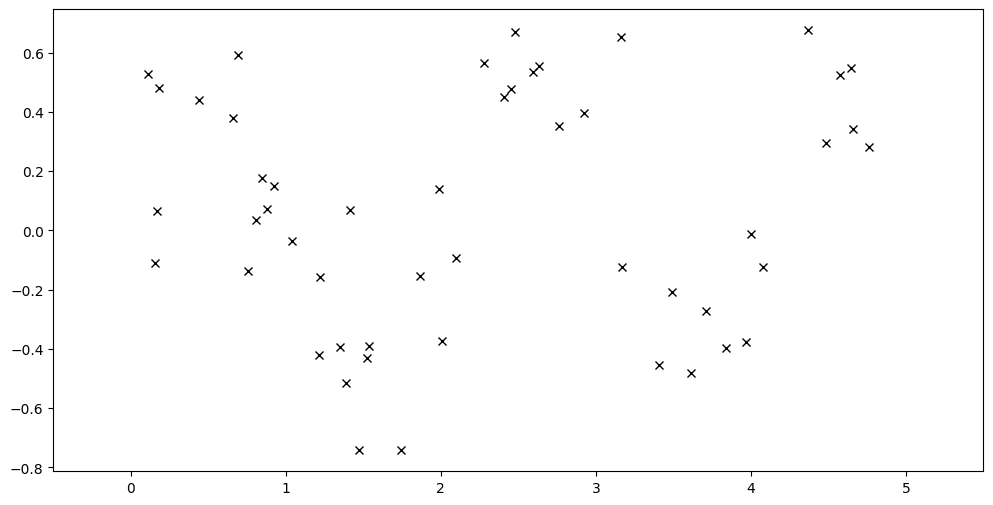

In [3]:
N = 50
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3 * X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))

plot(plot_observed_data=True)

### Model Definition

Beginning with the definition of the RBF kernel, we then construct a Gaussian Process regression object and sample from this prior without training it for our synthetic data.

In [4]:
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(0.05)
)
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.1))

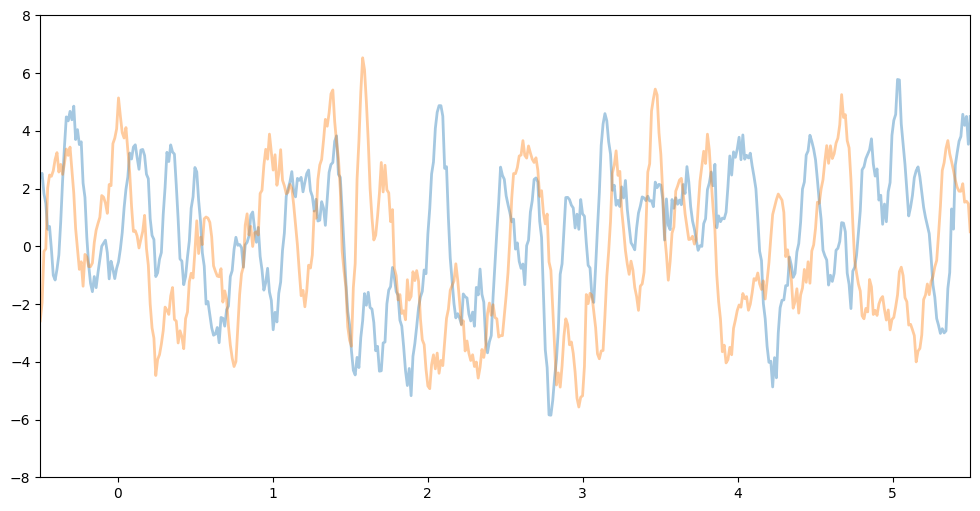

In [5]:
plot(model=gpr, kernel=kernel, n_prior_samples=2)
_ = plt.ylim((-8, 8))

* What would change if we increase the lengthscale? We will obtain much smoother function samples.
* In reverse, this means that the shorter the lengthscale the more rugged our function samples are.
* What happens if we reduce the variance and the noise? The vertical amplitude gets smaller and smaller.
* In reverse, this means that the larger the variance and the noise, the larger the vertical amplitude of our function samples.

In examples:

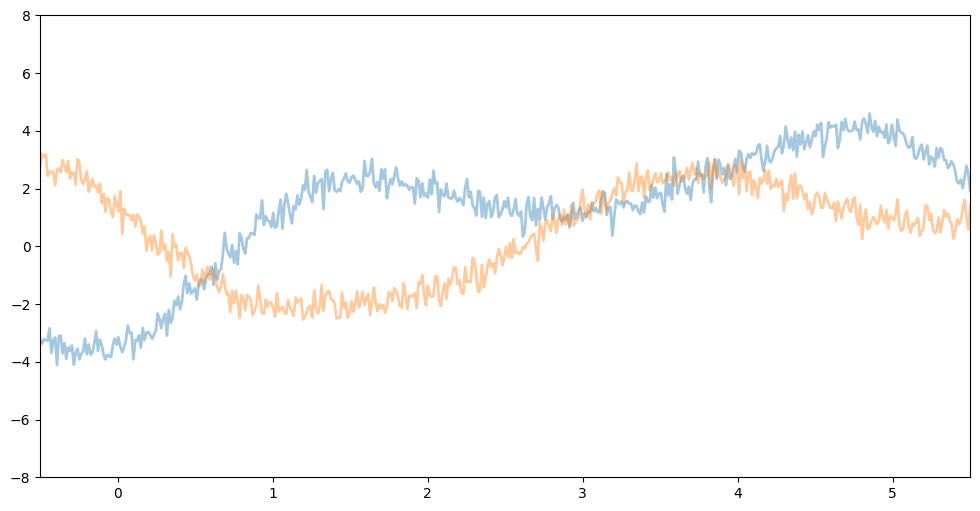

In [6]:
kernel2 = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(1)
)
gpr2 = gp.models.GPRegression(X, y, kernel2, noise=torch.tensor(0.1))
plot(model=gpr2, kernel=kernel2, n_prior_samples=2)
_ = plt.ylim((-8, 8))

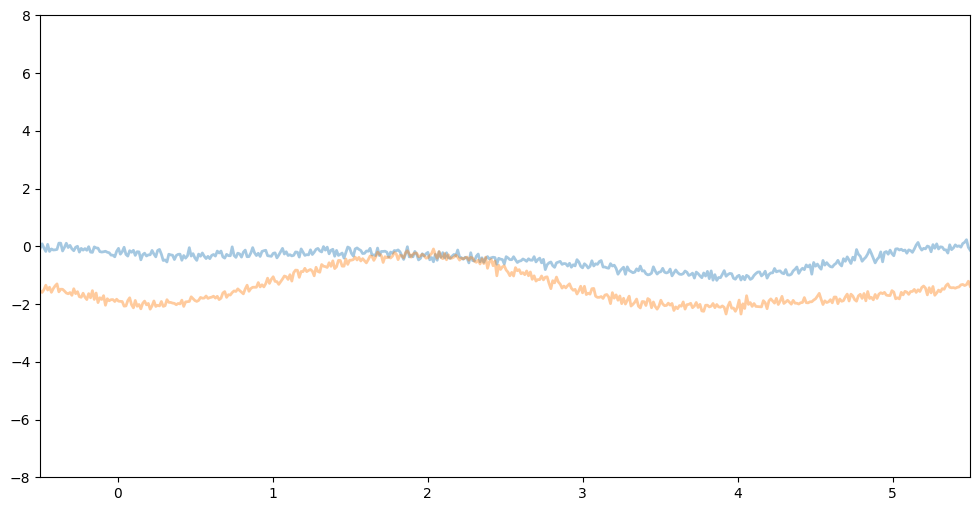

In [7]:
kernel3 = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(1)
)
gpr3 = gp.models.GPRegression(X, y, kernel3, noise=torch.tensor(0.01))
plot(model=gpr3, kernel=kernel3, n_prior_samples=2)
_ = plt.ylim((-8, 8))

### Inference

To now adjust the kernel hyperparameters to our synthetic data, we have to perform inference. For this we define ourselves the Evidence-Lower-Bound (ELBO), to the construct a scenario in which we essentially perform **gradient ascent** on the log marginal likelihood, i.e. we computationally solve the **Marginal Likelihood Estimation (MLE)** to infer the right

In [8]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variances = []
lengthscales = []
noises = []
num_steps = 2000
for i in range(num_steps):
    variances.append(gpr.kernel.variance.item())
    noises.append(gpr.noise.item())
    lengthscales.append(gpr.kernel.lengthscale.item())
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

Plotting the loss curve after 2000 training iterations

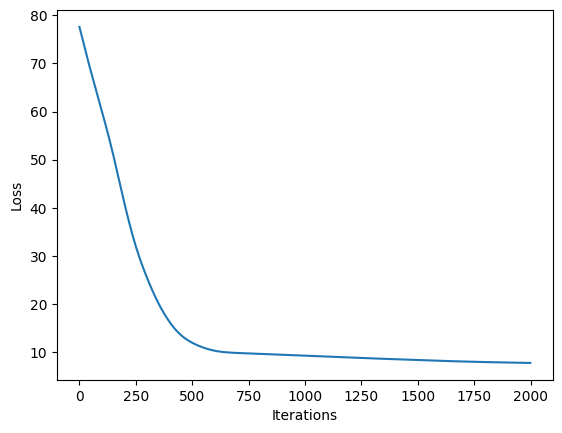

In [9]:
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


plot_loss(losses)

With that the behaviour of our Gaussian Process should now be much more reasonable, let's inspect it

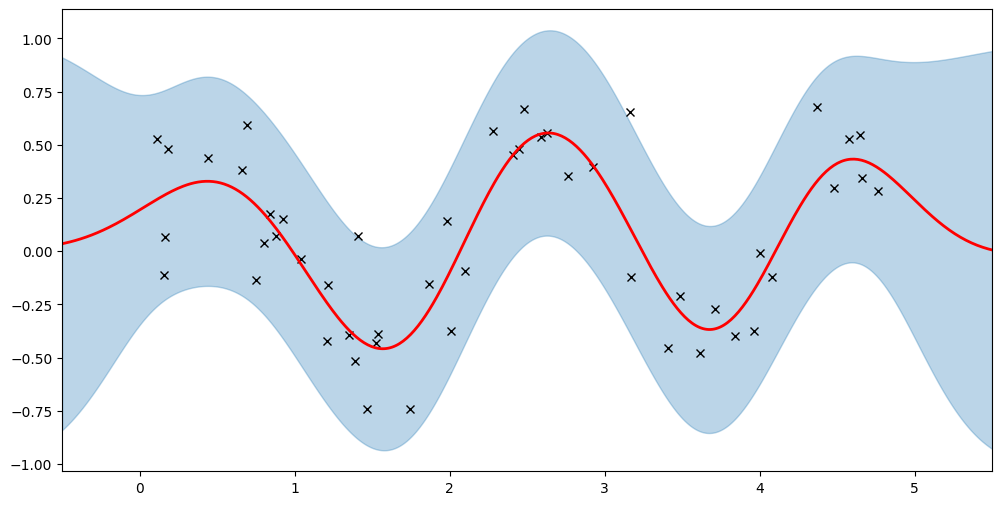

In [10]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

In this plot we have the typical case of GP representation:
* A, in this case red, line represents the mean prediction
* A shaded area, in this case blue, represents the 2-sigma uncertainty around the mean

But what are the actual hyperparameters we just learned?

In [11]:
gpr.kernel.variance.item()

0.1970929503440857

In [12]:
gpr.kernel.lengthscale.item()

0.5308124423027039

In [13]:
gpr.noise.item()

0.0501394160091877

The learning process can furthermore be illustrated for the GP's behaviour across training iterations:

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))


def update(iteration):
    pyro.clear_param_store()
    ax.cla()
    kernel_iter = gp.kernels.RBF(
        input_dim=1,
        variance=torch.tensor(variances[iteration]),
        lengthscale=torch.tensor(lengthscales[iteration]),
    )
    gpr_iter = gp.models.GPRegression(
        X, y, kernel_iter, noise=torch.tensor(noises[iteration])
    )
    plot(model=gpr_iter, plot_observed_data=True, plot_predictions=True, ax=ax)
    ax.set_title(f"Iteration: {iteration}, Loss: {losses[iteration]:0.2f}")


anim = FuncAnimation(fig, update, frames=np.arange(0, num_steps, 30), interval=100)
plt.close()

anim.save("../imgs/gpr-fit.gif", fps=60)

MovieWriter ffmpeg unavailable; using Pillow instead.


### Maximum a Posterior Estimation (MAP)

A second option is then to use MAP estimation for which we need to define priors over our hyperparameters to then infer the *true* hyperparameters.

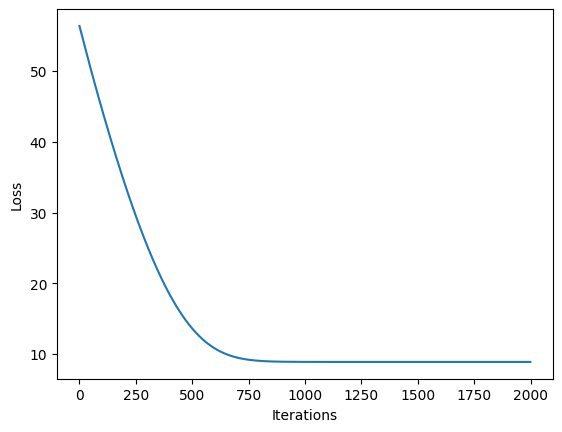

In [15]:
pyro.clear_param_store()
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(5.0), lengthscale=torch.tensor(10.0)
)
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1.0))

# Define the priors over our hyperparameters
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plot_loss(losses)

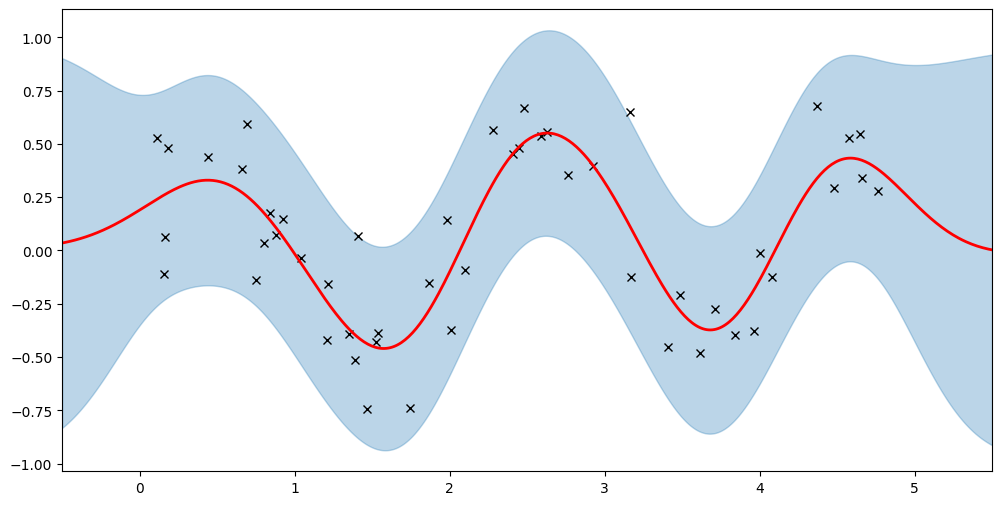

In [16]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

What we then realize is that due to the priors we have defined, we end up with different hyperparameters than under the Maximum Likelihood Estimation (MLE)

In [17]:
gpr.set_mode("guide")
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))
print("noise = {}".format(gpr.noise))

variance = 0.18086840212345123
lengthscale = 0.5018946528434753
noise = 0.05002214014530182


For the choice of prior we would ideally like to select parameters which maximise the model likelihood, which is defined by

$$
L = \Pi_{i=1}^{p} f(x_{i})
$$

For a single observation our likelihood would then be

$$
L(\sigma^{2}, \theta) = \frac{1}{(2\pi)^{\frac{n}{2}} |k(x, x)|^{\frac{1}{2}}} \exp \left( - \frac{1}{2} F^{\top} k(x, x)^{-1} F \right)
$$

We hence seek to **maximise** the likelihood, or the log-likelihood with respect to the kernel's parameters in order to find the most well-suited prior. As priors encode our prior belief over the function to approximate, they are hugely important choices to make which later on determine the performance of our Gaussian process. The question one should hence ask in selecting kernels are:

* Is my data stationary?
* Is it differentiable, if so what is it's regularity?
* Do I expect any particular trends?
* Do I expect periodicity, cycles, additivity, or other patterns?

### Gaussian Process Classification

To use Gaussian Processes for classification we first need to a softmax to our function prior

$$
p(y | f) = \text{Softmax}(f)
$$

or going further

$$
y \sim \text{Categorical}\left( \text{Softmax}(f) \right)
$$

using one of Seaborn's naturally provided datasets, the Iris dataset we can then construct a classification problem with 3 classes:

0. Setosa
1. Versicolor
2. Virginica

with just the petal length, and the petal width as input featurs.

In [18]:
df = sns.load_dataset("iris")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [19]:
X = torch.from_numpy(
    df[df.columns[2:4]].values.astype("float32"),
)
df["species"] = df["species"].astype("category")
# encode the species as 0, 1, 2
y = torch.from_numpy(df["species"].cat.codes.values.copy())

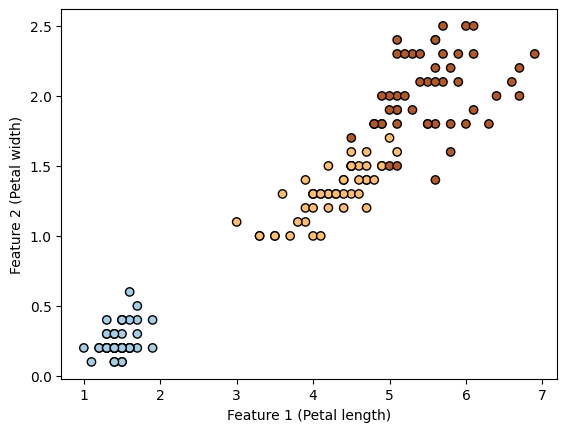

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors=(0, 0, 0))
plt.xlabel("Feature 1 (Petal length)")
_ = plt.ylabel("Feature 2 (Petal width)")

Using the classical RBF-kernel

In [21]:
kernel = gp.kernels.RBF(input_dim=2)
pyro.clear_param_store()
likelihood = gp.likelihoods.MultiClass(num_classes=3)
# Important -- we need to add latent_shape argument here to the number of classes we have in the data
model = gp.models.VariationalGP(
    X,
    y,
    kernel,
    likelihood=likelihood,
    whiten=True,
    jitter=1e-03,
    latent_shape=torch.Size([3]),
)
num_steps = 1000
loss = gp.util.train(model, num_steps=num_steps)

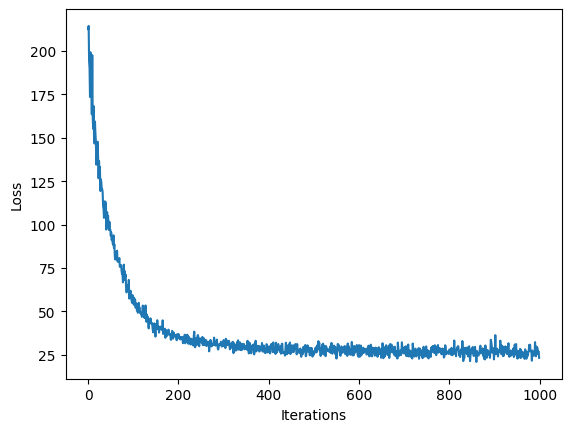

In [22]:
plot_loss(loss)

With which we can now inspect the accuracy of our classifier

In [23]:
mean, var = model(X)
y_hat = model.likelihood(mean, var)

print(f"Accuracy: {(y_hat==y).sum()*100/(len(y)) :0.2f}%")

Accuracy: 95.33%


And can furthermore use the confusion matrix to assess the accuracy of our predictions

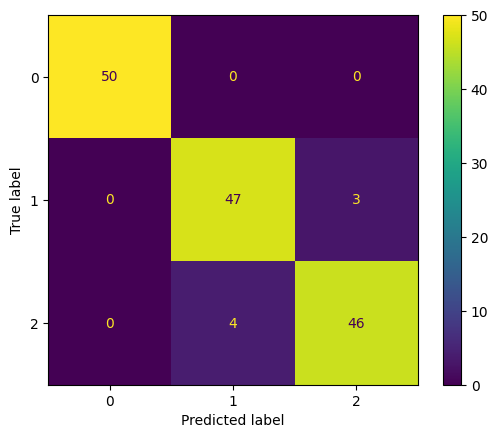

In [24]:
cm = confusion_matrix(y, y_hat, labels=[0, 1, 2])
ConfusionMatrixDisplay(cm).plot()

### Gaussian Process Classification: The tl;dr

Quickly summarizing GP classification (in a slightly different notation)

Based on the Bayesian methodology, where we have to assume an underlying prior distribution to guarantee smoothness with the final classifier then being a Bayesian classifier, which provides the best first for the observed data. The initial problem here is that our posterior is not directly Gaussian, as has to be presumed in a Gaussian process, i.e.

$$
p(f_{X}|Y) = \frac{\mathcal{N}(f_{X};m, k) \prod_{j=1}^{n} \sigma(y_{j}f_{x_{j}})}{\int \mathcal{N}(f_{X};m, k) \prod_{j=1}^{n}\sigma(y_{j}f_{x_{j}}) df_{X}}
$$

with the log-probability

$$    
\log p(f_{X}|Y) = - \frac{1}{2} f_{X}^{\top} k^{-1}_{XX} f_{X} + \sum_{j=1}^{n} \log \sigma(y_{j} f_{x_{j}}) + \text{ const.}
$$

We are then interested in the following moments of our probability distribution, which we first decompose as a conditional probability, i.e. $p(f, y) = p(y|f)p(f)$

$$
\mathbb{E}_{p}(1) = \int 1 \cdot p(y, f) df = Z \quad \text{the evidence}
$$

$$
\mathbb{E}_{p(f|y)}(f) = \frac{1}{Z} \int 1 \cdot p(f, y) df = \bar{f} \quad \text{the mean}
$$

$$
\mathbb{E}_{p(f|y)}(f^{2}) - \bar{f}^{2} = \frac{1}{Z} \int f^{2} \cdot p(f, y) df - \bar{f}^{2} = \text{var}(f) \quad \text{the variance}
$$

$Z$ is then used for hyperparameter tuning, $\bar{f}$ gives us a point estimator, and $\text{var}(f)$ is our error estimator. To gain a classification estimator with the Gaussian process estimator with the Gaussian Process framework, we have to utilize the Laplace approximation to gain a classification estimator. For the Gaussian Process framework we then have to find the maximum posterior probability for latent $f$ at training points

$$
\hat{f} = \arg \max \log p(f_{X}|y)
$$

by assigning approximate Gaussian posteriors at the training points

$$
q(f_{X}) = \mathcal{N}(f_{X}; \hat{f}, \hat{\Sigma}).
$$

Our Laplace approximation $q$ for the classification probability $p$ is then given by

$$
q(f_{X}|y) = \mathcal{N}(f_{X}; m_{x} + k_{xX} K_{XX}^{-1}(\hat{f} - m_{x}), k_{xx} - k_{xX} K_{XX}^{-1} k_{Xx} + k_{xX} K_{XX}^{-1} \hat{\Sigma} K_{XX}^{-1}k_{Xx}).
$$

With which we can then compute the label probabilities

$$
\mathbb{E}_{p(f|y)[\pi_{x}]} \approx \mathbb{E}_{q}[\pi_{x}] = \int \sigma(f_{x}) q(f_{x}|y) df_{x} \quad \text{or} \quad \hat{\pi}_{x} = \sigma(\mathbb{E}(f_{x})).
$$

The Laplace approximation is only locally valid, working well within the logistic regression framework as the log posterior is concave and the structure of the link function yields an almost Gaussian posterior.

The training algorithm is then given by

$$
\begin{align}
    &1 \quad \text{procedure GP-Logistic-Train}(K_{XX}, m_{X}, y) \\
    &2 \quad \quad f \longleftarrow m_{X} \quad \quad // \text{initialize} \\
    &3 \quad \quad \text{while not converged do} \\
    &4 \quad \quad \quad \quad r \longleftarrow \frac{y + 1}{2} - \sigma(f) \quad \quad // = \nabla \log p(y|f_{X}), \text{ gradient of log likelihood} \\
    &5 \quad \quad \quad \quad W \longleftarrow \text{diag}(\sigma(f) \odot (1 - \sigma(f))) \quad \quad // = - \nabla \nabla \log p(y|f_{X}), \text{ Hessian of log likelihood}\\
    &6 \quad \quad \quad \quad g \longleftarrow r - K_{XX}^{-1}(f - m_{X}) \quad \quad // \text{ compute gradient} \\
    &7 \quad \quad \quad \quad H \longleftarrow - (W + K^{-1})^{-1} \quad \quad // \text{ compute inverse Hessian} \\
    &8 \quad \quad \quad \quad \Delta \longleftarrow Hg \quad \quad // \text{ Newton step} \\
    &9 \quad \quad \quad \quad f \longleftarrow f - \Delta \quad \quad // \text{ perform step} \\
    &10 \quad \quad \quad \text{converged} \longleftarrow ||\Delta|| < \epsilon \quad \quad // \text{ check for convergence} \\
    &11 \quad \quad \text{end while} \\
    &12 \quad \quad \text{return } f \\
    &13 \quad \text{end procedure}
\end{align}
$$

and the prediction algorithm is given by

$$
\begin{align}
    &1 \quad \text{procedure GP-Logistic-Predict}(\hat{f}, W, R, r, k, x) \quad \quad // \hat{f}, W, R = \text{Cholesky}(B), r \text{ handed over from training}\\
    &2 \quad \quad \text{for } i=1, \ldots, \text{Length}(x) \text{ do} \\
    &3 \quad \quad \quad \bar{f}_{i} \longleftarrow k_{x_{i}X}r \quad \quad // \text{mean prediction } (\text{note at minimum, } 0 = \nabla p(f_{X}|y) = r - K^{-1}_{XX}(f_{X} - m_{X})) \\
    &4 \quad \quad \quad s \longleftarrow R^{-1}(W^{1/2}k_{Xx_{i}}) \quad \quad // \text{pre-computation allows this step in } \mathcal{O}(n^{2}) \\
    &5 \quad \quad \quad v \longleftarrow k_{x_{i}x_{i}} - s^{\top}s \quad \quad // v = \text{cov}(f_{X}) \\
    &6 \quad \quad \quad \bar{\pi}_{i} \longleftarrow \int \sigma(f_{i}) \mathcal{N}(f_{i}, \bar{f}_{i}, v)df_{i} \quad \quad // \text{predictive probability for class 1 is } p(y|\bar{f}) = \int p(y_{X}|f_{X})p(f_{X}| \bar{f})df_{X} \\
    &7 \quad \quad \text{end for} \quad \quad // \text{entire loop is } \mathcal{O}(n^{2}m) \text{ for m test cases}\\
    &8 \quad \quad \text{return } \bar{\pi}_{X} \\
    &9 \quad \text{end procedure}
\end{align}
$$

Gaussian classification does hence in summary amount to
* The model outputs are modeled as transformations of latent functions with Gaussian priors
* The non-Gaussian likelihood, the posterior is hence also non-Gaussian resulting in inference being intractable
* This requires us to utilize Laplace approximations
* With the Laplace approximations we then obtain Gaussian posteriors on training points

### Combining Kernels

Pyro provides utilities to combine the different kernels, the most important of which are shown by example below:

In [25]:
linear = gp.kernels.Linear(
    input_dim=1,
)
periodic = gp.kernels.Periodic(
    input_dim=1, period=torch.tensor(0.5), lengthscale=torch.tensor(4.0)
)
rbf = gp.kernels.RBF(
    input_dim=1, lengthscale=torch.tensor(0.5), variance=torch.tensor(0.5)
)
k1 = gp.kernels.Product(kern0=rbf, kern1=periodic)

k = gp.kernels.Sum(linear, k1)

## Remarks

* If you have to apply Gaussian Processes to large datasets, or the training is too slow for your liking, take a look at **Sparse Gaussian Processes**. This class of Gaussian Processes seeks to avoid the computational constraints of traditional Gaussian Processes.

## Tasks

##### Methods of Inference and the Computational Cost of Methods
* Explore the use of other inference methods to infer the hyperparameters of the Gaussian Processes Regression with Monte Carlo-style algorithms as you've encountered earlier in the course
    * Measure the difference in computational cost between the three approaches
* Repeat the same task for Gaussian Process Classification

##### Kernel Choices
* Experiment with the different combinations of the different kernels, visualize the combinations, and consider for which kind of function you would potentially use them
* Inspect the performance of your constructed kernels for GP Regression
* Repeat the same task for Gaussian Process Classification